In [156]:
import tensorflow as tf
import os

In [201]:
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [158]:
cpus = tf.config.experimental.list_physical_devices('GPU')
for cpu in cpus:
    tf.config.experimental.set_memory_growth(cpu, True)

In [159]:
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np

In [160]:
data_dir = 'dataset'

In [161]:
os.listdir(os.path.join(data_dir, 'normal'))

['row_10.png',
 'row_11.png',
 'row_12.png',
 'row_13.png',
 'row_14.png',
 'row_15.png',
 'row_25.png',
 'row_26.png',
 'row_27.png',
 'row_28.png',
 'row_29.png',
 'row_32.png',
 'row_33.png',
 'row_34.png',
 'row_35.png',
 'row_36.png',
 'row_37.png',
 'row_38.png',
 'row_39.png',
 'row_7.png',
 'row_8.png',
 'row_9.png',
 'st_CAB_output.jpg']

In [162]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [163]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [164]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

**Load Data**

In [165]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [166]:
#tf.keras.utils.image_dataset_from_directory??

In [167]:
# --- 1. Define 'data' ---
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',  # Infers labels from directory structure
    label_mode='categorical',  # One-hot encoded labels
    image_size=(256, 256),  # Adjust if your images have different dimensions
    batch_size=8,  # Adjust based on your memory constraints
)

Found 39 files belonging to 3 classes.


In [168]:
data_iterator = data.as_numpy_iterator()

In [169]:
batch = data_iterator.next()

In [170]:
batch[0].shape

(8, 256, 256, 3)

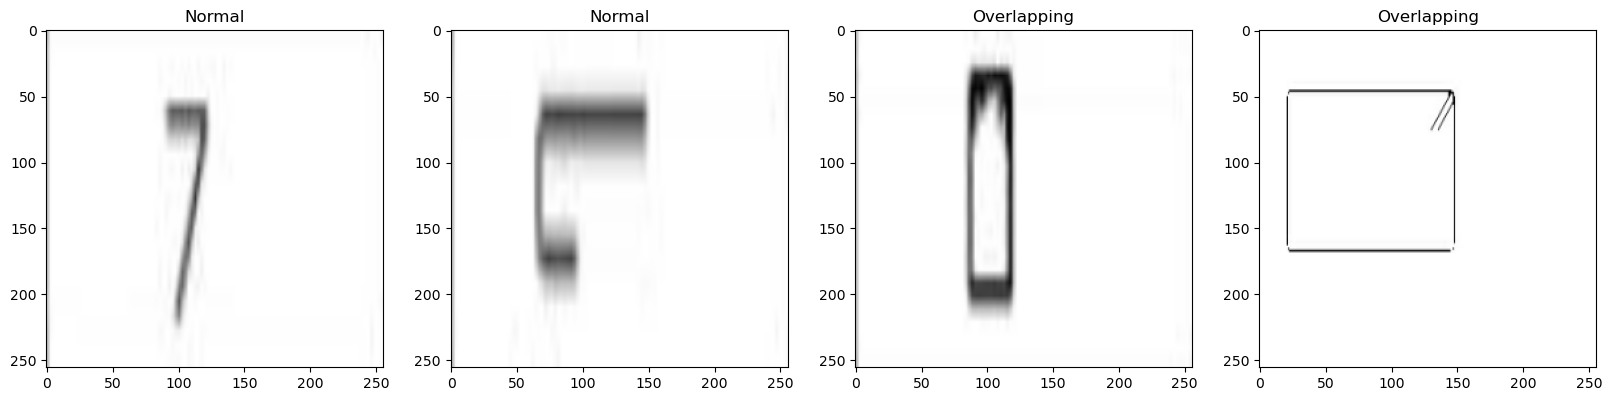

In [171]:
class_names = {
    0: "Circular",
    1: "Normal",
    2: "Overlapping"
}


fig, ax = plt.subplots(ncols=4, figsize=(20, 25))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # Convert NumPy array to a hashable type (e.g., integer)
    label_index = np.argmax(batch[1][idx])  # Get index of the highest probability class
    ax[idx].title.set_text(class_names.get(label_index, "Unknown"))

    # Add x and y ticks (adjust values based on your image dimensions)
    ax[idx].set_xticks(np.arange(0, img.shape[1], 50))  # Ticks every 50 pixels on x-axis
    ax[idx].set_yticks(np.arange(0, img.shape[0], 50))  # Ticks every 50 pixels on y-axis

    # Optionally, label the ticks with pixel values
    ax[idx].set_xticklabels(np.arange(0, img.shape[1], 50))
    ax[idx].set_yticklabels(np.arange(0, img.shape[0], 50))

plt.show()

**Scale Data**

In [172]:
data = data.map(lambda x,y: (x/255, y))
# important since it helps to perform transformation to convert image min to 0 and max to 1
# important while working with data pipeline

In [173]:
data.as_numpy_iterator().next()

(array([[[[0.7254902 , 0.7254902 , 0.7254902 ],
          [0.7571232 , 0.7571232 , 0.7571232 ],
          [0.8697151 , 0.8697151 , 0.8697151 ],
          ...,
          [0.9869715 , 0.9869715 , 0.9869715 ],
          [0.9757123 , 0.9757123 , 0.9757123 ],
          [0.972549  , 0.972549  , 0.972549  ]],
 
         [[0.7254902 , 0.7254902 , 0.7254902 ],
          [0.7571232 , 0.7571232 , 0.7571232 ],
          [0.8697151 , 0.8697151 , 0.8697151 ],
          ...,
          [0.9869715 , 0.9869715 , 0.9869715 ],
          [0.9757123 , 0.9757123 , 0.9757123 ],
          [0.972549  , 0.972549  , 0.972549  ]],
 
         [[0.7254902 , 0.7254902 , 0.7254902 ],
          [0.7571232 , 0.7571232 , 0.7571232 ],
          [0.8697151 , 0.8697151 , 0.8697151 ],
          ...,
          [0.9869715 , 0.9869715 , 0.9869715 ],
          [0.9757123 , 0.9757123 , 0.9757123 ],
          [0.972549  , 0.972549  , 0.972549  ]],
 
         ...,
 
         [[0.7294118 , 0.7294118 , 0.7294118 ],
          [0.76059

**Split Data**

In [174]:
len(data) # num of batches

5

In [175]:
#batch_size = 32

In [176]:
# train_batches = int(len(data) * 0.7) // batch_size
# val_batches = int(len(data) * 0.2) // batch_size
# test_batches = int(len(data) * 0.1) // batch_size

In [177]:
# test_batches

In [178]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [179]:
val_size

1

In [180]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Established train, test and val partition

In [181]:
train_labels = np.concatenate([y for x, y in train], axis=0)
val_labels = np.concatenate([y for x, y in val], axis=0)
test_labels = np.concatenate([y for x, y in test], axis=0)

# One-hot encode the labels (if needed for your model)
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

**Building the Deep Learning Model**

In [182]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [183]:
num_classes = 3
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

C:\Users\KIIT\anaconda3\envs\ai_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [184]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [185]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,139 (14.10 MB)

 Trainable params: 3,697,139 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

**Train**

In [186]:
logdir = 'logs'

In [187]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [188]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.7135 - loss: 1.4611 - val_accuracy: 0.0000e+00 - val_loss: 0.9411
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.4062 - loss: 0.9724 - val_accuracy: 0.6250 - val_loss: 0.9691
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6302 - loss: 0.9567 - val_accuracy: 0.7500 - val_loss: 0.8213
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.5469 - loss: 0.9118 - val_accuracy: 0.7500 - val_loss: 0.9406
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7240 - loss: 0.7984 - val_accuracy: 0.7500 - val_loss: 0.5725
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6667 - loss: 0.6575 - val_accuracy: 1.0000 - val_loss: 0.5350
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9271 - loss: 0.5781 - val_accuracy: 1.0000 - val_loss: 0.3282
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9635 - loss: 0.3719 - val_accuracy: 1.0000 - val_l

In [189]:
hist.history

{'accuracy': [0.7083333134651184,
  0.5,
  0.6666666865348816,
  0.5,
  0.6666666865348816,
  0.7083333134651184,
  0.9166666865348816,
  0.9583333134651184,
  0.9166666865348816,
  0.875,
  0.9583333134651184,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [1.5356035232543945,
  0.9861618876457214,
  0.945726215839386,
  0.9505812525749207,
  0.7896413803100586,
  0.6862892508506775,
  0.5890000462532043,
  0.3582618236541748,
  0.3329072892665863,
  0.2895421087741852,
  0.11785820871591568,
  0.08857167512178421,
  0.04091789200901985,
  0.016450800001621246,
  0.008333244360983372,
  0.006730387452989817,
  0.0029730263631790876,
  0.007207595277577639,
  0.000925928121432662,
  0.0015593821881338954],
 'val_accuracy': [0.0,
  0.625,
  0.75,
  0.75,
  0.75,
  1.0,
  1.0,
  1.0,
  1.0,
  0.875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.9410971403121948,
  0.9691463708877563,
  0.8213155269622803,
  0.940645217895

**Plot Performance**

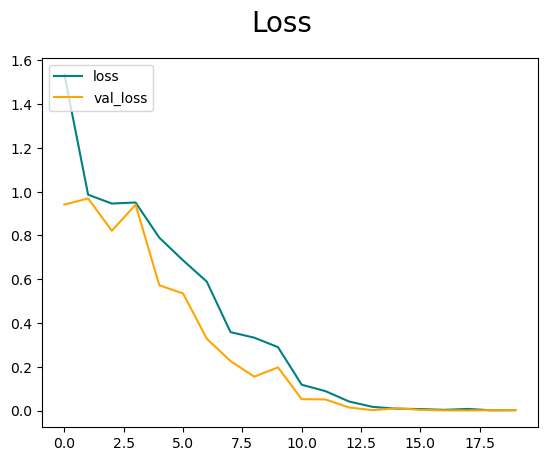

In [190]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

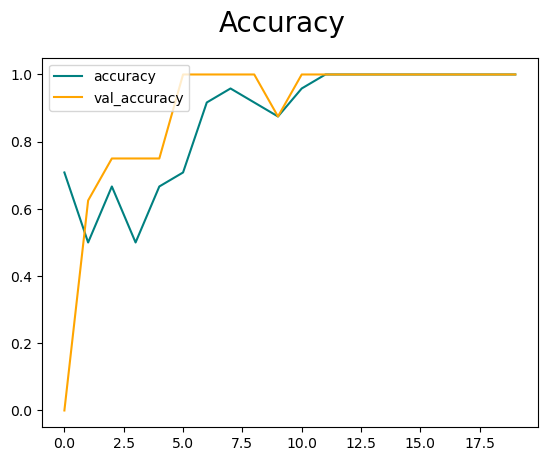

In [191]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Evaluate Performance**

In [192]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [193]:
# Establishing instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [194]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


In [195]:
print(f'Precision:{pre.result()}, Recall:{re.result().numpy()}, Acuraccy:{acc.result().numpy}')

Precision:1.0, Recall:1.0, Acuraccy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


**Test**

In [196]:
import cv2

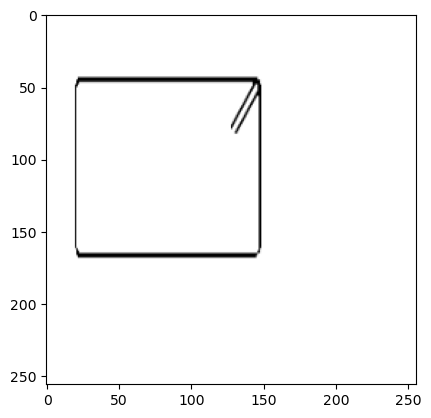

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image belong to the Overlapping class


In [197]:
# Load and preprocess the image
img = cv2.imread('eval3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class
predict = model.predict(np.expand_dims(resize/255, 0))

# Assuming you have 3 classes (Sad, Happy, Neutral)
class_names = ['Circular', 'Normal', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

**Saving the model**

In [198]:
from tensorflow.keras.models import load_model

In [199]:
model.save('imageclassifier.keras')